In [1]:
# --- Setup & Imports ----------------------------------------------------------
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import pickle
from scipy import stats
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd
from scipy.stats import pearsonr, linregress
# Point Python to your src/ folder
sys.path.append(os.path.abspath("../src"))

from preprocessing import *
from NPI import *
from group_analysis import *
from connectivity import *


# Import Connectome and Atlas data

In [2]:
# Define base path (adjust depending on where you run the notebook)
base_dir = os.path.abspath('..')  # go one level up from /notebooks
data_dir = os.path.join(base_dir, 'data', 'connectome')

# Load .mat files
#path_AAL = os.path.join(data_dir, 'AAL_labels_complete_symmetric.mat')
path_PET = os.path.join(data_dir, 'Hansen_NM_PET_Maps.mat')
path_RSN = os.path.join(data_dir, 'RSNsAAL_non-symmetric.mat')
path_SC  = os.path.join(data_dir, 'SC.mat')

#AAL_labels = loadmat(path_AAL)
PET_maps   = loadmat(path_PET)
RSNsAAL    = loadmat(path_RSN)
SC_mat         = loadmat(path_SC)

# Quick check of the variables inside each file
#print("AAL_labels keys:", AAL_labels.keys())
print("PET_maps keys:", PET_maps.keys())
print("RSNsAAL keys:", RSNsAAL.keys())
print("SC keys:", SC_mat.keys())

PET_maps keys: dict_keys(['__header__', '__version__', '__globals__', 'Maps_Labels', 'NM_PET_Maps'])
RSNsAAL keys: dict_keys(['__header__', '__version__', '__globals__', 'Yeo_AAL'])
SC keys: dict_keys(['__header__', '__version__', '__globals__', 'C'])


In [3]:
# Resting State Networks
RSNs_labels = ['Visual', 'Somatomotor', 'Dorsal Attn', 'Sal-VentAttn', 'Limbic', 'Control', 'Default']

RSN_probs=RSNsAAL['Yeo_AAL']
# 1. Assign each ROI to the RSN with maximum probability (0–6)
RSNs_max_prob = np.argmax(RSN_probs, axis=0)  # shape (90,)
# 2. Reorder ROIs so that all Left (L) come before Right (R) as in [L0, L1, ..., LN, RN, ...,R1, R0]
L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
RSNs = np.concatenate([RSNs_max_prob[L_ids], RSNs_max_prob[R_ids][::-1]])
RSNs

array([1, 6, 4, 5, 5, 5, 5, 6, 1, 3, 4, 6, 6, 4, 3, 6, 3, 6, 6, 4, 4, 0,
       0, 0, 0, 0, 0, 0, 1, 2, 5, 3, 6, 6, 1, 4, 0, 0, 0, 1, 1, 4, 6, 4,
       4, 4, 4, 6, 4, 1, 1, 0, 0, 3, 4, 1, 6, 6, 3, 5, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 4, 4, 4, 6, 3, 6, 3, 4, 6, 6, 4, 1, 1, 6, 5, 5, 5, 5, 4,
       6, 1])

In [4]:
# labels to sort by RSNs
order=np.argsort(RSNs, kind='stable')
order_mat=np.ix_(order,order)
RSN_ordered = RSNs[order] 
RSN_ordered

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6])

In [5]:
# Load the CSV
df_aal = pd.read_csv(data_dir+'/aal.csv', header=None)

ROIs_labels = df_aal.iloc[:, 0].astype(str).str.strip().tolist()

print(f"Loaded {len(ROIs_labels)} ROI labels")
print("Example:", ROIs_labels[:10])

Loaded 90 ROI labels
Example: ['L Precentral', 'L Frontal Sup', 'L Front Sup Orb', 'L Front Mid', 'L Front Mid Orb', 'L Front Inf Ope', 'L Front Inf Tri', 'L Front Inf Orb', 'L Rolandic Oper', 'L Supp Motor Ar']


In [6]:
# Structural Connectivity
SC=SC_mat['C']

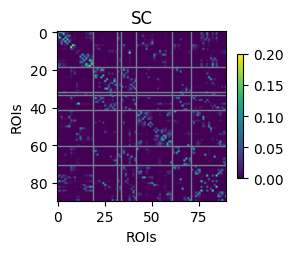

In [7]:
plt.figure(figsize=(3,3,))
plt.imshow(SC[order_mat].T)
plt.colorbar(shrink=0.5)
plt.title('SC')
plt.xlabel('ROIs')
plt.ylabel('ROIs')

# --- compute boundaries between networks ---
boundaries = np.where(np.diff(RSN_ordered) != 0)[0] + 1
# --- draw separator lines ---
for b in boundaries:
    plt.axhline(b - 0.5, color='slategray', lw=1)
    plt.axvline(b - 0.5, color='slategray', lw=1)
    
plt.tight_layout()
plt.show()

In [8]:
# Extract labels and flatten to clean strings
labels = [str(l[0]) for l in PET_maps['Maps_Labels'].squeeze()]
maps = PET_maps['NM_PET_Maps'][:, :90]  # shape (19, 90)

L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
ordr=np.hstack((L_ids,R_ids[::-1]))
maps=maps[:,ordr]

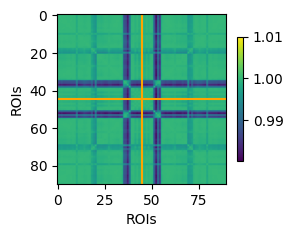

In [9]:
plt.figure(figsize=(3,3,))
plt.imshow(np.corrcoef(maps.T),vmax=1.01)
plt.axhline(45-0.5,c='orange')
plt.axvline(45-0.5,c='orange')
plt.colorbar(shrink=0.5)
plt.xlabel('ROIs')
plt.ylabel('ROIs')
plt.tight_layout()
plt.show()

In [10]:
# Create dict: {label: (90,) array}
PET_dict = {label: maps[i, :] for i, label in enumerate(labels)}

In [11]:
PET_dict.keys()

dict_keys(['5HT1a', '5HT1b', '5HT2a', '5HT4', '5HT6', '5HTT', 'A4B2', 'CB1', 'D1', 'D2', 'DAT', 'GABAa', 'H3', 'M1', 'mGluR5', 'MOR', 'NET', 'NMDA', 'VAChT'])

In [12]:
PET_dict['5HT1a'].shape

(90,)

# Import fMRI data

In [13]:
# build the path relative to your notebook
file_path = os.path.join("../data/fmri/ts_coma24_AAL_symm.mat")

# Path to your file
#file_path = os.path.join("..", "data", "fmri", "ts_coma24_AAL_symm.mat")

# Load the .mat file
mat_data = sio.loadmat(file_path)

# Inspect available keys (variables inside the .mat file)
print("Keys in .mat file:", mat_data.keys())

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'timeseries_CNT24_symm', 'timeseries_MCS24_symm', 'timeseries_UWS24_symm'])


In [14]:
# Path
file_path = os.path.join("..", "data", "fmri", "ts_coma24_AAL_symm.mat")

# Load
mat_data = sio.loadmat(file_path)

# Extract groups
ts_controls = mat_data["timeseries_CNT24_symm"]
ts_mcs      = mat_data["timeseries_MCS24_symm"]
ts_uws      = mat_data["timeseries_UWS24_symm"]

print("Controls:", ts_controls.shape)
print("MCS:", ts_mcs.shape)
print("UWS:", ts_uws.shape)

Controls: (1, 13)
MCS: (1, 11)
UWS: (1, 10)


In [15]:
# Unpack each group
controls = unpack_group(ts_controls)
mcs      = unpack_group(ts_mcs)
uws      = unpack_group(ts_uws)

# --- add preprocessing (k=2 Butterworth 0.01–0.08 Hz) plus zscore ---
controls = preprocess_groups(controls)
mcs      = preprocess_groups(mcs)
uws      = preprocess_groups(uws)

print(f"Controls: {len(controls)} subjects → subj[0] shape {controls[0].shape}")
print(f"MCS:      {len(mcs)} subjects → subj[0] shape {mcs[0].shape}")
print(f"UWS:      {len(uws)} subjects → subj[0] shape {uws[0].shape}")


Controls: 13 subjects → subj[0] shape (192, 90)
MCS:      11 subjects → subj[0] shape (192, 90)
UWS:      10 subjects → subj[0] shape (192, 90)


In [48]:
T=mcs[0].shape[0]   # time points
N=mcs[0].shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

In [16]:
groups = {"CNT": controls, "MCS": mcs, "UWS": uws}
groups_id = list(groups.keys())

In [57]:
cols = {"CNT": "#DCA258", "MCS": "#AA7798", "UWS": "#524F88"}
markers = {"CNT": "o", "MCS": "s", "UWS": "^"}

# Personalized ANN

In [18]:
# -----------------------
# Train ANN for each participant
# -----------------------
# Assuming `groups` is like:
# groups = {"CNT": [np.ndarray(T,N), ...], "MCS": [...], "UWS": [...]}

models_by_group = train_models_for_groups(
    groups,
    steps=3,
    num_epochs=100,
    lr=1e-3,
    l2=5e-5,
    save_dir=None  # or None to skip saving
)

# Quick summary print
for g, lst in models_by_group.items():
    print(f"{g}: {len(lst)} trained models")
    if lst:
        h = lst[0]["history"]
        print(f"  example final losses — train {h['train_loss'][-1]:.6f}, test {h['test_loss'][-1]:.6f}")


=== Group: CNT — 13 subjects ===
[OK]  CNT[0] — T=192, N=90, W=189 | final train=0.062559, test=0.526106 (5.1s)
[OK]  CNT[1] — T=192, N=90, W=189 | final train=0.083068, test=0.462961 (1.7s)
[OK]  CNT[2] — T=192, N=90, W=189 | final train=0.096968, test=0.468102 (1.8s)
[OK]  CNT[3] — T=192, N=90, W=189 | final train=0.033299, test=0.575453 (1.5s)
[OK]  CNT[4] — T=192, N=90, W=189 | final train=0.043170, test=0.619950 (1.5s)
[OK]  CNT[5] — T=192, N=90, W=189 | final train=0.052150, test=0.459522 (1.2s)
[OK]  CNT[6] — T=192, N=90, W=189 | final train=0.042610, test=0.605270 (1.3s)
[OK]  CNT[7] — T=192, N=90, W=189 | final train=0.038367, test=0.742080 (1.5s)
[OK]  CNT[8] — T=192, N=90, W=189 | final train=0.069009, test=0.486293 (1.3s)
[OK]  CNT[9] — T=192, N=90, W=189 | final train=0.034776, test=0.578288 (1.2s)
[OK]  CNT[10] — T=192, N=90, W=189 | final train=0.049725, test=0.410266 (1.3s)
[OK]  CNT[11] — T=192, N=90, W=189 | final train=0.045787, test=0.491557 (1.3s)
[OK]  CNT[12] — 

In [19]:
import torch
import pickle
import os

save_path = "../results/ANNs_DOC/models_by_group.pkl"
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Create a serializable version: save weights separately, keep history/meta in pickle
serializable = {}

for group, entries in models_by_group.items():
    serializable[group] = []
    for i, entry in enumerate(entries):
        model = entry["model"]

        # Save model weights per subject
        weights_path = f"../results/ANNs_DOC/{group}_sub{entry['subject_idx']}_weights.pt"
        torch.save(model.state_dict(), weights_path)

        # Copy all non-model info
        meta_entry = {k: v for k, v in entry.items() if k != "model"}
        meta_entry["weights_path"] = weights_path
        serializable[group].append(meta_entry)

# Save the metadata + paths
with open(save_path, "wb") as f:
    pickle.dump(serializable, f)

print(f"✅ Saved metadata to {save_path}")

✅ Saved metadata to ../results/ANNs_DOC/models_by_group.pkl


In [20]:
models_by_group['CNT'][0].keys()

dict_keys(['model', 'history', 'subject_idx', 'shapes', 'train_time_s'])

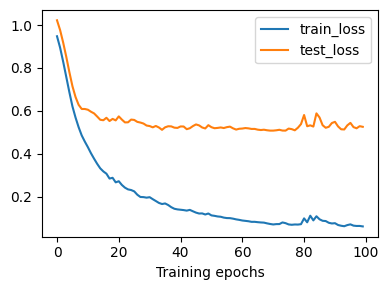

In [21]:
plt.figure(figsize=(4,3))
plt.plot(models_by_group['CNT'][0]['history']['train_loss'],label='train_loss')
plt.plot(models_by_group['CNT'][0]['history']['test_loss'],label='test_loss')
plt.legend()
plt.xlabel('Training epochs')
plt.tight_layout()
plt.show()

# Empirical and Simulated time series, example subject 0, CNT group

In [22]:
emp=groups["CNT"][0]
emp.shape

(192, 90)

In [23]:
FC_emp=np.corrcoef(emp.T)
FC_emp.shape

(90, 90)

In [24]:
dFC_emp=dFC(emp)
dFC_emp.shape

(192, 192)

In [25]:
S=3 #number of steps
N=emp.shape[1] #number of regions
sim = model_time_series(models_by_group['CNT'][0]['model'], np.zeros((S,N)), tlen=500, noise_strength=.5)
sim=sim[-192:,:]
sim.shape

(192, 90)

In [26]:
FC_sim=np.corrcoef(sim.T)
FC_sim.shape

(90, 90)

In [27]:
dFC_sim=dFC(sim)
dFC_sim.shape

(192, 192)

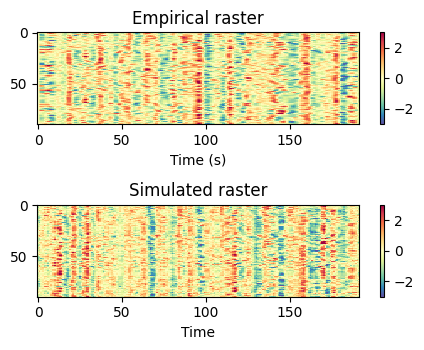

In [28]:
plt.figure(figsize=(4.6,3.6))
plt.subplot(2,1,1)
plt.title('Empirical raster')
plt.imshow(stats.zscore(emp,axis=0)[:,:].T,aspect='auto',vmin=-3,vmax=3,cmap='Spectral_r',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time (s)')
plt.subplot(2,1,2)
plt.title('Simulated raster')
plt.imshow(stats.zscore(sim,axis=0)[:,:].T,aspect='auto',vmin=-3,vmax=3,cmap='Spectral_r',interpolation='nearest')
plt.colorbar()
plt.xlabel('Time')
#plt.axis('off')
plt.tight_layout()
plt.show()

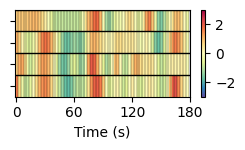

In [29]:
plt.figure(figsize=(2.6,1.6))
plt.imshow(stats.zscore(emp,axis=0)[-60:,:4].T,aspect='auto',vmin=-3,vmax=3,cmap='Spectral_r',interpolation='nearest')
plt.axhline(-0.49,linewidth=1,c='k')
plt.axhline(.49,linewidth=1,c='k')
plt.axhline(1.49,linewidth=1,c='k')
plt.axhline(2.49,linewidth=1,c='k')
plt.colorbar()
plt.xlabel('Time (s)')
for i in range(60):
    plt.axvline(i+0.5,linewidth=.25,c='k')
plt.yticks([0,1,2,3],['','','',''])
plt.xticks([0,20,40,60],[0,60,120,180])
#plt.axis('off')
plt.tight_layout()
#plt.savefig('Emp_signals.png',dpi=300, transparent=True)
plt.show()

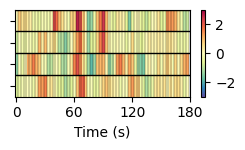

In [30]:
plt.figure(figsize=(2.6,1.6))
plt.imshow(stats.zscore(sim,axis=0)[:60,:4].T,aspect='auto',vmin=-3,vmax=3,cmap='Spectral_r',interpolation='nearest')
plt.axhline(-0.49,linewidth=1,c='k')
plt.axhline(.49,linewidth=1,c='k')
plt.axhline(1.49,linewidth=1,c='k')
plt.axhline(2.49,linewidth=1,c='k')
plt.colorbar()
plt.xlabel('Time (s)')
for i in range(60):
    plt.axvline(i+0.5,linewidth=.25,c='k')
plt.yticks([0,1,2,3],['','','',''])
plt.xticks([0,20,40,60],[0,60,120,180])
#plt.axis('off')
plt.tight_layout()
#plt.savefig('Sim_signals.png',dpi=300, transparent=True)
plt.show()

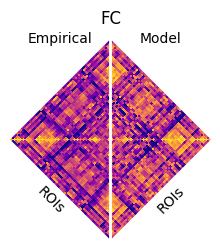

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# dFC_emp and dFC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = 0, 1

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(FC_emp, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(FC_sim, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='plasma', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# --- grid aligned to the rotated matrices ---
#n_grid = 8  # number of grid divisions (adjust as desired)
#ticks = np.linspace(-1, 1, n_grid+1)
#for t in ticks:
#    ax.plot([t, t], [-1, 1], lw=0.6, color='w', alpha=0.6, transform=rot)
#    ax.plot([-1, 1], [t, t], lw=0.6, color='w', alpha=0.6, transform=rot)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'FC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'ROIs', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()


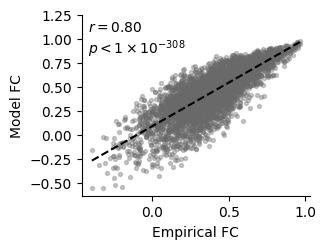

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# --- take upper triangle (excluding diagonal) ---
tri = np.triu_indices_from(FC_emp, k=1)
x = FC_emp[tri].astype(float).ravel()
y = FC_sim[tri].astype(float).ravel()

# remove NaNs / infs if any
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# stats
r, p = pearsonr(x, y)
lr = linregress(x, y)  # slope, intercept, rvalue, pvalue, stderr, intercept_stderr

# --- plot ---
fig, ax = plt.subplots(figsize=(3.4, 2.6))
ax.scatter(x, y, s=8, alpha=0.35,c='dimgray')

# regression line
xx = np.linspace(x.min(), x.max(), 200)
ax.plot(xx, lr.slope * xx + lr.intercept, linewidth=1.5,c='k',linestyle='--')

# identity line for reference
#lo, hi = min(x.min(), y.min()), max(x.max(), y.max())
#ax.plot([lo, hi], [lo, hi], linestyle='--', linewidth=1)

ax.set_xlabel('Empirical FC')
ax.set_ylabel('Model FC')
#ax.set_title('Empirical vs. Model FC')

# format p-value as mantissa × 10^{exponent}
if p == 0:
    p_str = r"$p < 1\times 10^{-308}$"   # avoids log10(0)
else:
    exponent = int(np.floor(np.log10(p)))
    mantissa = p / 10**exponent
    p_str = rf"$p = {mantissa:.2f}\times 10^{{{exponent}}}$"

# annotate correlation + p-value
ax.text(0.03, 0.97, rf"$r = {r:.2f}$" + "\n" + p_str,
        transform=ax.transAxes, ha="left", va="top")

# turn off top and right axes spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ticks = ax.get_xticks()
ax.set_yticks(ticks)

plt.tight_layout()
#plt.savefig('FC_emp_vs_sim_scatter.png',dpi=300, transparent=True)
plt.show()


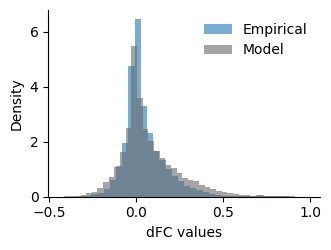

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

# --- take upper triangle (excluding diagonal) ---
tri = np.triu_indices_from(dFC_emp, k=1)
x = dFC_emp[tri].astype(float).ravel()
y = dFC_sim[tri].astype(float).ravel()

# remove NaNs / infs if any
m = np.isfinite(x) & np.isfinite(y)
x, y = x[m], y[m]

# --- KS test ---
D, p = ks_2samp(x, y)

# format p-value as mantissa × 10^{exponent}
if p == 0:
    p_str = r"$p < 1\times 10^{-308}$"
else:
    exponent = int(np.floor(np.log10(p)))
    mantissa = p / 10**exponent
    p_str = rf"$p = {mantissa:.2f}\times 10^{{{exponent}}}$"

# --- plot ---
fig, ax = plt.subplots(figsize=(3.4, 2.6))

# histograms
bins = 40
ax.hist(x, bins=bins, alpha=0.6, label="Empirical", density=True)
ax.hist(y, bins=bins, alpha=0.6, label="Model", density=True, color='dimgray')

ax.set_xlabel('dFC values')
ax.set_ylabel('Density')

# annotate KS test results
#ax.text(0.03, 0.97, rf"$D = {D:.2f}$" + "\n" + p_str,
#        transform=ax.transAxes, ha="left", va="top")

# tidy up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# legend (move outside the plot to avoid overlap)
# Put legend at upper right, labels below the boxes
# shrink current axis by 20% (leave room on the right)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# now put legend to the right
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()
#plt.savefig('dFC_emp_vs_sim_hist.png', dpi=300, transparent=True)
plt.show()


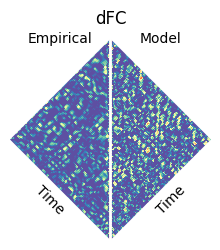

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib.patches import Polygon

# dFC_emp and dFC_sim are square (n x n) numpy arrays
# Example color limits (change if you like)
vmin, vmax = -0, 1.

# We'll place the (0..1, 0..1) image into a square [-1,1]x[-1,1] then rotate 45°
extent = (-1, 1, -1, 1)

fig, ax = plt.subplots(figsize=(2.6,2.6))
ax.set_aspect('equal')
ax.set_axis_off()

# 45° rotation for anything that should align with the matrix axes (images + grid)
rot = Affine2D().rotate_deg(45) + ax.transData

# --- draw left (Empirical) half ---
im_emp = ax.imshow(dFC_emp, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=rot,interpolation='nearest')
# clip to left triangle (x <= 0 in unrotated data coords)

# Y label (left, vertical)
clip_left = Polygon([(-1, 0), (0, 1), (0, -1)], closed=True,
                    facecolor='none', edgecolor='none', transform=ax.transData)
im_emp.set_clip_path(clip_left)

# --- draw right (Model) half ---
im_sim = ax.imshow(dFC_sim, origin='lower', extent=extent,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r', transform=rot,interpolation='nearest')

# Y label (left, vertical)
# clip to right triangle (x >= 0)
clip_right = Polygon([(0, -1), (0, 1), (1, 0)], closed=True,
                     facecolor='none', edgecolor='none', transform=ax.transData)
im_sim.set_clip_path(clip_right)

# --- grid aligned to the rotated matrices ---
#n_grid = 8  # number of grid divisions (adjust as desired)
#ticks = np.linspace(-1, 1, n_grid+1)
#for t in ticks:
#    ax.plot([t, t], [-1, 1], lw=0.6, color='w', alpha=0.6, transform=rot)
#    ax.plot([-1, 1], [t, t], lw=0.6, color='w', alpha=0.6, transform=rot)

# central separator
ax.plot([0, 0], [-1, 1], color='w', lw=2)

# labels
ax.text(0., 1.2, 'dFC', color='k', ha='center', va='center',
        fontsize=12)

ax.text(-0.5, 1.0, 'Empirical', color='k', ha='center', va='center',
        fontsize=10)
ax.text(0.5, 1.0, 'Model', color='k', ha='center', va='center',
        fontsize=10)

# Y-axis label (left center, rotated)
ax.text(-.6, -0.6, 'Time', ha='center', va='center',
        fontsize=10, rotation=-45)

# Y-axis label (left center, rotated)
ax.text(0.6, -0.6, 'Time', ha='center', va='center',
        fontsize=10, rotation=45)

plt.tight_layout()
#plt.savefig('dFC_emp_vs_sim.png',dpi=300, transparent=True)
plt.show()


# # Empirical and simulated / static and dynamic FC for all subjects

In [102]:
# Empirical static and dynamic FC for all subjects
FCs_emp={}
dFCs_emp={}
for g in groups_id:
    FCs_emp[g]={}
    dFCs_emp[g]={}
    for isu in range(len(groups[g])):
        emp=groups[g][isu]
        FCs_emp[g][isu]=np.corrcoef(emp.T)
        dFCs_emp[g][isu]=dFC(emp)

In [103]:
# Simulated static and dynamic FC for all subjects
FCs_sim={}
dFCs_sim={}
for g in groups_id:
    FCs_sim[g]={}
    dFCs_sim[g]={}
    for isu in range(len(groups[g])):
        S=3 #number of steps
        sim = model_time_series(models_by_group[g][isu]['model'], np.zeros((S,N)), tlen=500, noise_strength=.5)
        sim=sim[-T:,:]
        FCs_sim[g][isu]=np.corrcoef(sim.T)
        dFCs_sim[g][isu]=dFC(sim)

In [104]:
Corr_FC_emp_VS_sim={} 
Fluidity_emp={}
Fluidity_sim={}
for g in groups_id:
    Corr_FC_emp_VS_sim[g]={}
    Fluidity_emp[g]={}
    Fluidity_sim[g]={}
    for isu in range(len(groups[g])):
        Corr_FC_emp_VS_sim[g][isu]=stats.pearsonr(FCs_emp[g][isu][tri_N],FCs_sim[g][isu][tri_N])[0]
        Fluidity_emp[g][isu]=np.var(dFCs_emp[g][isu][tri_T])
        Fluidity_sim[g][isu]=np.var(dFCs_sim[g][isu][tri_T])

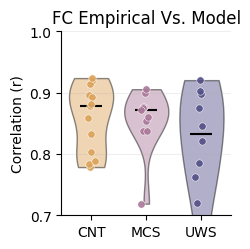

In [105]:
data = {g: np.asarray(list(Corr_FC_emp_VS_sim[g].values())) for g in groups_id}

# ----- plot -----
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_title('FC Empirical Vs. Model')
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("Correlation (r)")
ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

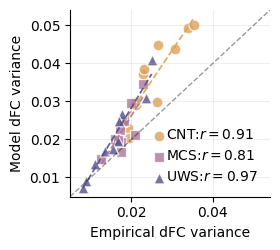

In [124]:
fig, ax = plt.subplots(figsize=(2.9, 2.6))

legend_handles = []
legend_labels = []

for g in groups_id:
    # align subjects present in both dicts
    idx = sorted(set(Fluidity_emp[g].keys()) & set(Fluidity_sim[g].keys()))
    x = np.array([Fluidity_emp[g][i] for i in idx], float)  # empirical
    y = np.array([Fluidity_sim[g][i] for i in idx], float)  # model

    # scatter
    sc = ax.scatter(x, y, s=60, marker=markers[g], color=cols[g],
                    edgecolor="white", linewidth=0.9, alpha=0.8)

    # regression line
    lr = linregress(x, y)
    xx = np.linspace(x.min(), x.max(), 200)
    ax.plot(xx, lr.slope*xx + lr.intercept, color=cols[g],
            linewidth=1.25, alpha=0.9,linestyle="--")

    # correlation coefficient
    r, p = pearsonr(x, y)

    # legend handle/label (symbol + color + r only)
    legend_handles.append(sc)
    legend_labels.append(f"{g}:$r={r:.2f}$")

# identity line
lims = np.array([ax.get_xlim(), ax.get_ylim()])
lo, hi = lims.min(), lims.max()
ax.plot([lo, hi], [lo, hi], ls="--", lw=1, color="k", alpha=0.4)
ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)

# labels
ax.set_xlabel("Empirical dFC variance")
ax.set_ylabel("Model dFC variance")

# clean style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(alpha=0.2)

# legend
ax.legend(legend_handles, legend_labels, frameon=False, loc="lower right",handletextpad=-0.5)

plt.tight_layout()
#plt.savefig("dFC_variance_scatter_by_group.png", dpi=300, transparent=True)
plt.show()



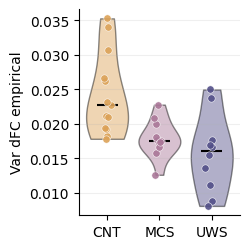

In [129]:
data = {g: np.asarray(list(Fluidity_emp[g].values())) for g in groups_id}

# ----- plot -----
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("Var dFC empirical")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

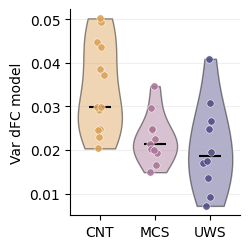

In [130]:
data = {g: np.asarray(list(Fluidity_sim[g].values())) for g in groups_id}

# ----- plot -----
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("Var dFC model")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()